In [263]:
%reload_ext autoreload
%reload_ext line_profiler
%autoreload 2

import numpy as np
from joblib import Memory
from sklearn.datasets import load_svmlight_file
from sklearn.kernel_approximation import RBFSampler
from scipy.spatial.distance import pdist
import tqdm



In [1]:
mem = Memory("./mycache")

@mem.cache
def get_data():
    data = load_svmlight_file("/Users/nikosk.REDMOND/Downloads/xaa")
    return data[0], data[1]

X, y = get_data()

________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-nikosk.REDMOND-Desktop-projects-pycharm-opebet-%3Cipython-input-cb5b6702a785%3E.get_data...
get_data()
_______________________________________________________get_data - 121.9s, 2.0min


In [5]:
x = X.todense().A.astype(np.float32)
del X
x /= 255.
xx = x.T@x

In [6]:
d,v = np.linalg.eigh(xx)
perm = np.argsort(-d)
print((np.cumsum(d[perm])/sum(d))[100])
print( np.linalg.norm(v.T@xx@v,'fro'))
print( np.linalg.norm(v[:,perm[:-1]].T@xx@v[:,perm[:-1]],'fro'))
print( np.linalg.norm(v[:,perm[1:]].T@xx@v[:,perm[1:]],'fro'))
print( np.linalg.norm(v[:,perm[:100]].T@xx@v[:,perm[:100]],'fro'))
vv = v[:,perm[:50]]

0.94979686
37820956.0
37820960.0
8159595.0
37819732.0


In [33]:
#vv = vv[:,:50]

In [22]:
xv = x@vv
del x
print(xv.dtype)

float32


In [34]:
class RFF():
    def __init__(self, x, gamma=None, n_components=None, seed=90210):
        n, d = x.shape
        self.d = d
        self.c = n_components if n_components is not None else int(np.round(np.sqrt(n)))
        self.seed = seed
        self.rs = np.random.RandomState(self.seed)
        if gamma is None:
            n_samples = min(n, 1000)
            perm = self.rs.permutation(n)[:n_samples]
            gamma = np.median(pdist(x[perm]).ravel())**(-2) 
        print(gamma)
        self.gamma = gamma
        self.omega = self.rs.normal(size=(d, self.c)).astype(np.float32)
        self.omega *= np.sqrt(2 * self.gamma)
        self.b = self.rs.uniform(0, 2*np.pi, size=self.c).astype(np.float32)
        self.normalizer = np.sqrt(2./self.c)
    
    def __call__(self,x):
        projection = np.dot(x, self.omega) + self.b
        np.cos(projection, projection)
        projection *= self.normalizer
        return projection

rff = RFF(xv)
rffxv = rff(xv)
print(rffxv.dtype)

0.012065846657620543
float32


In [24]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False).fit(y.reshape(-1,1))
y = ohe.transform(y.reshape(-1,1))

In [25]:
y.shape

(1000000, 10)

In [35]:
rxx=np.dot(rffxv.T,rffxv)

In [36]:
from scipy.linalg import cho_factor, cho_solve
rcf = cho_factor(rxx+1e-12*np.eye(rxx.shape[0]))

In [38]:
def agd(x,y,c=None):
    nx, d = x.shape
    ny, k = y.shape 
    assert nx == ny
    n = nx
    from scipy.linalg import cho_factor, cho_solve
    if c is None:
        xx=np.dot(x.T,x)
        c = cho_factor(xx+1e-12*np.eye(xx.shape[0]))
    li, nextli = (1,1)
    u = np.zeros((d,k), dtype=np.float32)
    w = np.zeros((d,k), dtype=np.float32)
    t = np.zeros((d,k), dtype=np.float32)
    p = np.zeros((n,k), dtype=np.float32)
    z = np.zeros(n, dtype=np.float32)
    g = np.zeros((d,k), dtype=np.float32)
    for i in range(100):
        np.dot(x, u, out=p)
        np.max(p, axis=1, out=z)
        p -= z.reshape(-1,1)
        np.exp(p, out=p)
        np.sum(p, axis=1, out=z)
        p /= z.reshape(-1,1)
        p -= y
        np.dot(x.T, p, out=g)
        gnorm = np.sum(g*g)/(n*d*k)  
        print(i, gnorm)
        if gnorm < 1e-4:
            break
        gi = (1-li) / nextli
        t[:] = gi * w[:]                    
        np.subtract(u, cho_solve(c,g), out=w)
        np.add((1-gi) * w, t, out=u)
        li=nextli
        nextli=(1+np.sqrt(1+4*li*li))/2;
    return w

In [39]:
w = agd(rffxv,y,c=rcf)

0 0.8397011968
1 0.6272526336
2 0.3982569472
3 0.2001848832
4 0.0937900288
5 0.0461673024
6 0.024591752
7 0.0141343456
8 0.0086822784
9 0.005644428
10 0.0038504224
11 0.0027363602
12 0.0020139426
13 0.0015277166
14 0.0011897791
15 0.0009482657
16 0.00077138905
17 0.0006389986
18 0.0005379341
19 0.00045937285
20 0.00039726725
21 0.0003473893
22 0.000306734125
23 0.000273135725
24 0.00024501295
25 0.000221197725
26 0.000200817375
27 0.000183213975
28 0.000167885375
29 0.00015444425
30 0.000142587175
31 0.0001320738875
32 0.0001227113
33 0.00011434235
34 0.0001068365875
35 0.00010008544375
36 9.39968875e-05


In [40]:
from sklearn.metrics import accuracy_score
am = np.argmax(rffxv@w, axis=1)
y_pred = np.zeros((rffxv.shape[0], y.shape[1]))
y_pred[range(rffxv.shape[0]), am] = 1
accuracy_score(y, y_pred)

0.972201

0.961368

In [44]:
def agdilr(x,y,c=None):
    nx, d = x.shape
    ny, k = y.shape 
    assert nx == ny
    n = nx
    from scipy.linalg import cho_factor, cho_solve
    from scipy.special import expit
    if c is None:
        xx=np.dot(x.T,x)
        c = cho_factor(xx+1e-12*np.eye(xx.shape[0]))
    li, nextli = (1,1)
    u = np.zeros((d,k), dtype=np.float32)
    w = np.zeros((d,k), dtype=np.float32)
    t = np.zeros((d,k), dtype=np.float32)
    p = np.zeros((n,k), dtype=np.float32)
    z = np.zeros(n, dtype=np.float32)
    g = np.zeros((d,k), dtype=np.float32)
    for i in range(100):
        np.dot(x, u, out=p)
        expit(p, p)
        p -= y
        np.dot(x.T, p, out=g)
        gnorm = np.sum(g*g)/(n*d*k)  
        print(i, gnorm)
        if gnorm < 1e-4:
            break
        gi = (1-li) / nextli
        t[:] = gi * w[:]                    
        np.subtract(u, cho_solve(c,g), out=w)
        np.add((1-gi) * w, t, out=u)
        li=nextli
        nextli=(1+np.sqrt(1+4*li*li))/2;
    return w

In [45]:
q = agdilr(rffxv,y,c=rcf)

0 61.221535744
1 34.9249339392
2 21.1837599744
3 12.1602449408
4 6.9052243968
5 3.9821623296
6 2.3633063936
7 1.451759616
8 0.924770816
9 0.6106794496
10 0.4174431488
11 0.2947483904
12 0.2144180608
13 0.1602549248
14 0.1227004672
15 0.0959671104
16 0.07646272
17 0.0619049088
18 0.0508106496
19 0.042195632
20 0.0353931904
21 0.0299427616
22 0.025520064
23 0.0218922992
24 0.0188891616
25 0.016383816
26 0.01428
27 0.0125034536
28 0.0109959736
29 0.0097112688
30 0.0086120888
31 0.007668132
32 0.006854552
33 0.0061508028
34 0.00553984
35 0.005007442
36 0.0045417148
37 0.0041327036
38 0.0037720648
39 0.0034527712
40 0.0031689296
41 0.002915585
42 0.0026885764
43 0.0024843836
44 0.002300063
45 0.0021331194
46 0.0019814444
47 0.001843248
48 0.0017170044
49 0.0016014191
50 0.0014953741
51 0.0013979014
52 0.001308166
53 0.0012254412
54 0.0011490768
55 0.0010785011
56 0.0010132093
57 0.0009527435
58 0.0008966938
59 0.0008446908
60 0.0007963991
61 0.0007515114
62 0.000709753
63 0.0006708639
64 0.

In [47]:
from sklearn.metrics import accuracy_score
from scipy.special import expit
hot = expit(rffxv@q)
for i in range(10):
    y_pred = hot[:,i]>0.5
    print(i,accuracy_score(y[:,i], y_pred))

0 0.997228
1 0.998195
2 0.991589
3 0.990065
4 0.992592
5 0.991161
6 0.995679
7 0.992974
8 0.985472
9 0.984788


In [48]:
wlin = agd(xv,y)

0 1603.230629888
1 1263.608922112
2 950.19204608
3 644.2008576
4 419.37453056
5 277.317189632
6 189.474684928
7 133.55880448
8 96.842244096
9 72.175280128
10 55.305801728
11 43.58098944
12 35.296559104
13 29.335875584
14 24.955824128
15 21.65480448
16 19.09192704
17 17.035148288
18 15.328275456
19 13.868148736
20 12.58890752
21 11.449623552
22 10.425668608
23 9.502058496
24 8.6690048
25 7.919021568
26 7.2455552
27 6.641996288
28 6.101702144
29 5.617986048
30 5.1842688
31 4.794212352
32 4.441944576
33 4.122116096
34 3.830009344
35 3.561547008
36 3.313306624
37 3.082529024
38 2.867016704
39 2.665133568
40 2.47570944
41 2.297939712
42 2.131324032
43 1.975548032
44 1.8304064
45 1.69573312
46 1.571302016
47 1.45681536
48 1.351875328
49 1.255970048
50 1.16848576
51 1.08874112
52 1.0160128
53 0.949566464
54 0.888674752
55 0.832657088
56 0.780882432
57 0.732794816
58 0.68791744
59 0.645847296
60 0.606257536
61 0.568894016
62 0.533566016
63 0.500133216
64 0.46850144
65 0.438605344
66 0.41040646

In [49]:
from sklearn.metrics import accuracy_score
am = np.argmax(xv@wlin, axis=1)
y_pred = np.zeros((xv.shape[0], y.shape[1]))
y_pred[range(xv.shape[0]), am] = 1
accuracy_score(y, y_pred)

0.84299

In [50]:
np.savez('mnist_models.npz',v=vv,omega=rff.omega,b=rff.b,z=rff.normalizer,wlin=wlin,w=w,q=q)

In [56]:
with np.load('mnist_models.npz') as npz:
    for i in npz:
        foo = npz[i].ravel()
        print(i, np.sum(foo*foo))

v 50.000004
omega 1218.599
b 13269.479
z 0.002
wlin 122.612854
w 245522.19
q 669745.25


In [67]:
for name in dir():
    if name.startswith('_'): continue
    #if isinstance(globals()[name], np.ndarray):
    print(name, type(globals()[name]))

In <class 'list'>
Memory <class 'type'>
OneHotEncoder <class 'type'>
Out <class 'dict'>
RBFSampler <class 'type'>
RFF <class 'type'>
accuracy_score <class 'function'>
agd <class 'function'>
agdilr <class 'function'>
cho_factor <class 'function'>
cho_solve <class 'function'>
exit <class 'IPython.core.autocall.ZMQExitAutocall'>
expit <class 'numpy.ufunc'>
gamma <class 'numpy.float64'>
get_data <class 'joblib.memory.MemorizedFunc'>
get_ipython <class 'method'>
i <class 'str'>
load_svmlight_file <class 'function'>
mem <class 'joblib.memory.Memory'>
name <class 'str'>
np <class 'module'>
npz <class 'numpy.lib.npyio.NpzFile'>
ohe <class 'sklearn.preprocessing._encoders.OneHotEncoder'>
pdist <class 'function'>
quit <class 'IPython.core.autocall.ZMQExitAutocall'>
rcf <class 'tuple'>
rff <class '__main__.RFF'>
sampler <class 'sklearn.kernel_approximation.RBFSampler'>


In [68]:
@mem.cache
def get_more_data():
    data = load_svmlight_file("/Users/nikosk.REDMOND/Downloads/xab")
    return data[0], data[1]

X, y = get_more_data()

________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-nikosk.REDMOND-Desktop-projects-pycharm-opebet-%3Cipython-input-ddb79f39b99e%3E.get_more_data...
get_more_data()
__________________________________________________get_more_data - 120.5s, 2.0min


In [ ]:
from scipy.special import softmax

class behavior_policy(object):
    def __init__(self, name):
        with np.load(name) as npz:
            self.v = npz['v']
            self.w = npz['wlin']
        k = self.w.shape[1]
        self.u = np.ones(k)/k
        self.m = 0.9
        
    def __call__(self, x):
        t = self.m*softmax((x @ self.v) @ self.w, axis=-1)+(1-self.m)*self.u
        t /= t.sum(axis=-1, keepdims=1)
        return np.squeeze(t)
    
class eval_policy(object):
    def __init__(self, name):
        with np.load(name) as npz:
            self.v = npz['v']
            self.f = npz['omega']
            self.b = npz['b']
            self.z = npz['z']
            self.w = npz['w']
        
    def __call__(self, x):
        rff = ((x/255.) @ self.v) @ self.f + self.b
        np.cos(rff, out=rff)
        rff *= self.z
        t = softmax(rff @ self.w, axis=-1)
        t /= t.sum(axis=-1, keepdims=1)
        return np.squeeze(t)
    
class reward_predictor(object):
    def __init__(self, name):
        with np.load(name) as npz:
            self.v = npz['v']
            self.f = npz['omega']
            self.b = npz['b']
            self.z = npz['z']
            self.q = npz['q']
        
    def __call__(self, x):
        rff = ((x/255.) @ self.v) @ self.f + self.b
        np.cos(rff, out=rff)
        rff *= self.z
        t = expit(rff @ self.q)
        return np.squeeze(t)

h = behavior_policy('mnist_models.npz')
pi = eval_policy('mnist_models.npz')
q = reward_predictor('mnist_models.npz')

In [135]:
wr = []
for xi,yi in tqdm.tqdm(zip(X,y),total=y.size, ncols=80):
    hxi = h(xi)
    ai = np.random.choice(10,p=hxi)
    ri = 1 if ai == yi else 0
    pxi = pi(xi)
    qxi = q(xi)
    wi = pxi[ai]/hxi[ai]
    cv = wi*qxi[ai]-np.dot(pxi,qxi)
    wr.append((wi,ri,cv))

In [124]:
wrc=np.array(wr)
import pickle
#with open('wrc.pkl','wb') as pkl:
#    pickle.dump(wr,pkl)
    
with open('wrc.pkl','rb') as pkl:
    wr2 = pickle.load(pkl)

wrc2 = np.array(wr2)
np.linalg.norm(wrc - wrc2,'fro')

0.0

In [107]:
np.mean(wrc,axis=0)

array([ 0.99770687,  0.765664  , -0.00215478])

In [157]:
np.mean(wrc[:,0]*wrc[:,1]-1.05*wrc[:,2])

0.9384672012222802

In [146]:
chunk = 1000
reward_pi = 0
reward_h = 0
iy = y.astype(np.int32)

for i in tqdm.trange(0,1000000,chunk):
    probs = pi(X[i:i+chunk])
    reward_pi += np.sum(probs[range(chunk),iy[i:i+chunk]])
    probs = h(X[i:i+chunk])
    reward_h += np.sum(probs[range(chunk),iy[i:i+chunk]])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:52<00:00, 19.13it/s]


In [147]:
print('pi on-policy reward:',reward_pi/y.size)
print('h  on-policy reward:',reward_h/y.size)

pi on-policy reward: 0.9384872605037115
h  on-policy reward: 0.7660206690954457


In [169]:
np.var(wrc[:,0]*wrc[:,1]-0*wrc[:,2])

10.704865452558229

In [176]:
for t in 0.0,0.5,1.0,1.05,1.1,2.0,3.0:
    print(t,np.round(np.var(wrc[:,0]*wrc[:,1])/np.var(wrc[:,0]*wrc[:,1]-t*wrc[:,2]),2))

0.0 1.0
0.5 3.04
1.0 13.17
1.05 13.6
1.1 13.28
2.0 1.22
3.0 0.31


In [186]:
perm = np.argsort(wrc[:10000,0])
np.round(wrc[:10000][perm][:,[0,2]],2)

array([[ 0.  , -1.  ],
       [ 0.  , -1.  ],
       [ 0.  , -1.  ],
       ...,
       [99.02, 96.9 ],
       [99.65, 98.52],
       [99.98, 98.96]])

[(-1.0, -1.0), (-1.0, 0.0), (-1.0, 1.0), (0.0, -1.0), (0.0, 0.0), (0.0, 1.0), (99.0, -100.0), (99.0, -99.0), (99.0, -1.0), (99.0, 0.0), (99.0, 1.0), (99.0, 99.0), (99.0, 100.0)]
1+-1.0*x+y*(0.0-v)>=0
1+-1.0*x+y*(1.0-v)>=0
1+0.0*x+y*(0.0-v)>=0
1+0.0*x+y*(1.0-v)>=0
1+99.0*x+y*(-99.0-v)>=0
1+99.0*x+y*(0.0-v)>=0
1+99.0*x+y*(1.0-v)>=0
1+99.0*x+y*(100.0-v)>=0
[(-1, -100), (-1, -99), (-1, 0), (-1, 1), (99, -100), (99, -99), (99, 0), (99, 1), (99, 100), (99, 101)]
1+(-1.0)*x+y*(-1.0)>=0
1+(-1.0)*x+y*(0.0)>=0
1+(-1.0)*x+y*(1.0)>=0
1+(0.0)*x+y*(-1.0)>=0
1+(0.0)*x+y*(0.0)>=0
1+(0.0)*x+y*(1.0)>=0
1+(99.0)*x+y*(-100.0)>=0
1+(99.0)*x+y*(-99.0)>=0
1+(99.0)*x+y*(-1.0)>=0
1+(99.0)*x+y*(0.0)>=0
1+(99.0)*x+y*(1.0)>=0
1+(99.0)*x+y*(99.0)>=0
1+(99.0)*x+y*(100.0)>=0


In [234]:
import cvxpy as cp

[-1. -1. -1.] -0.9999999834570823
[-1. -1.  0.] -0.9999999834051565
[ 0. -1. -1.] -0.9999999834576057
[ 0. -1.  0.] -0.9999999834027733
[ 0. 99. -1.] -0.9999999921714251
[  0.  99. 100.] -0.9999999917600422
[99. 99. -1.] -0.9999999921713894
[ 99.  99. 100.] -0.9999999917619511
[ 0.  0. -1.] 5.686443538266417e-10
[0. 0. 0.] 1.0
[0. 0. 1.] 5.721119133994534e-10
[ 0. 99.  0.] 1.901335755505329e-10
[ 0. 99. 99.] 1.930569037966734e-10
[99. 99.  0.] 1.9013191021599596e-10
[99. 99. 99.] 1.9304813303477886e-10


[-1.  0.] -inf
[-1.  1.] 6.992992851451163e-10
[0. 0.] 1.0
[0. 1.] 0.7487437203436901
[ 99. -99.] -inf
[99.  0.] 0.4999999999650564
[99.  1.] 0.4999999999653658
[ 99. 100.] -48.99999998526398


In [578]:
import opebetrp

def bet_3d(data, wmin, wmax, alpha):
    lb, ub = opebetrp.wealth_lb_3d(data, wmin, wmax, alpha)
    return np.array(lb), np.array(ub)

def bet_rp(data, wmin, wmax, alpha):
    lb, ub = opebetrp.wealth_lb_rp(data, wmin, wmax, alpha)
    return np.array(lb), np.array(ub)

def bet_double_rp(data, wmin, wmax, alpha):
    lb, ub = opebetrp.wealth_lb_rp_double_hedge(data, wmin, wmax, alpha)
    return np.array(lb), np.array(ub)

In [599]:
import opebet

def bet_2d(data, wmin, wmax, alpha):
    lb, ub = opebet.wealth_lb_2d(data, wmin, wmax, alpha)
    return np.array(lb), np.array(ub)

In [608]:
wrcflass = np.copy(wrc[:,0:2])
flb = 0
fub = 0
N = 5
for i in range(N):
    lb, ub = bet_2d(wrcflass[10000*i:10000*(i+1)], 0, 100, 0.001)
    print(ub[-1])
    flb = flb + lb
    fub = fub + ub
lb = flb/N
ub = fub/N

0.970970970970971
0.96996996996997
0.963963963963964
0.968968968968969
0.96996996996997


In [612]:
wrcalt = np.copy(wrc)
flb = 0
fub = 0
for i in range(N):
    lbalt, ubalt = bet_3d(wrcalt[10000*i:10000*(i+1)], 0, 100, 0.001)
    flb = flb + lbalt
    fub = fub + ubalt
lbalt = flb/N
ubalt = fub/N

100%|█████████████████████████████████████| 10000/10000 [02:58<00:00, 56.12it/s]


In [583]:
wrcdouble = np.copy(wrc)
flb = 0
fub = 0
M = 5
for i in range(M):
    lbhalf, ubhalf = bet_double_rp(wrcdouble[10000*i:10000*(i+1)], 0, 100, 0.001)
    flb = flb + lbhalf
    fub = fub + ubhalf
lbhalf = flb/M
ubhalf = fub/M

100%|█████████████████████████████████████| 10000/10000 [07:24<00:00, 22.48it/s]


[None]

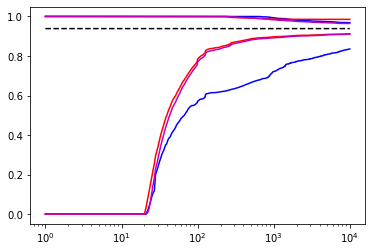

In [615]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
t = 1+np.arange(len(lb))
talt = 1+np.arange(len(lbalt))
thalf = 1+np.arange(len(lbhalf))
ax.plot(t,lb,'b-',)
ax.plot(t,ub,'b-')
ax.plot(talt,lbalt,'r-')
ax.plot(talt,ubalt,'r-')
ax.plot(thalf,lbhalf,'m-')
ax.plot(thalf,ubhalf,'m-')
truth = 0.9384872605037115*np.ones_like(lb)
ax.plot(t,truth,'k--')
ax.set(xscale='log')

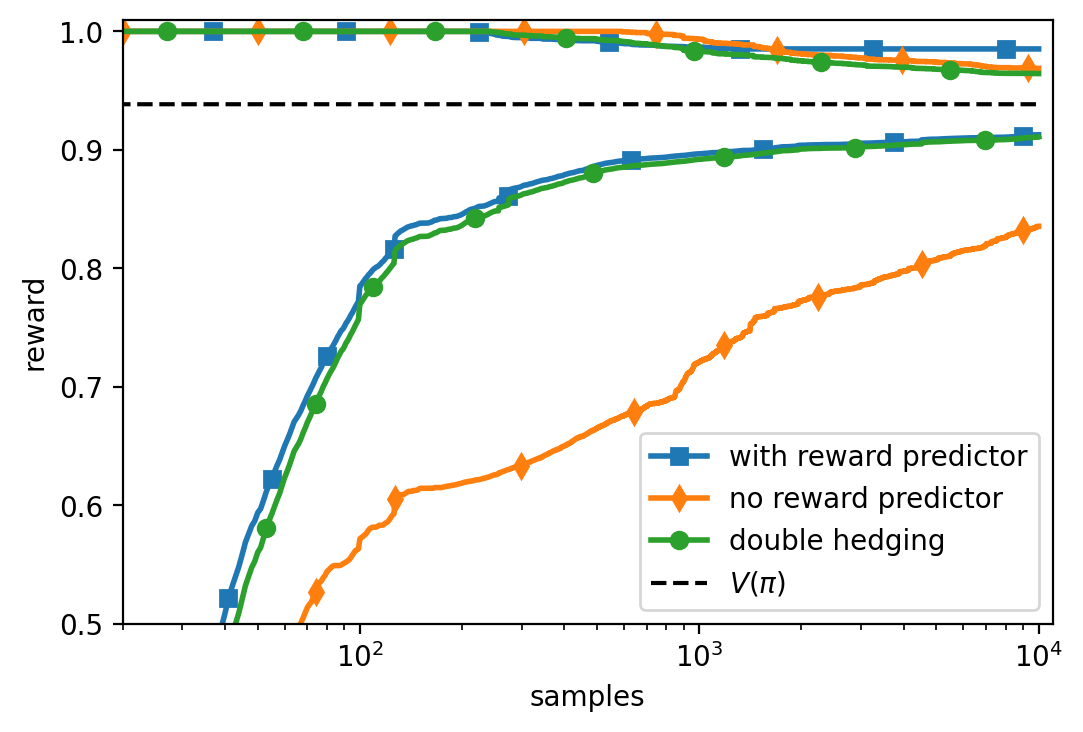

In [674]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap    
fig, ax = plt.subplots(dpi=200)
colors = get_cmap("tab10").colors 
#ax.set_prop_cycle(color=colors)
t = 1+np.arange(len(lb))
talt = 1+np.arange(len(lbalt))

d1 = dict(linestyle='-', marker='s', markevery=(0.00,0.12), color=colors[0], linewidth=2.0)
d2 = dict(linestyle='-', marker='d', markevery=(0.04,0.12), color=colors[1], linewidth=2.0)
d3 = dict(linestyle='-', marker='o', markevery=(0.08,0.12), color=colors[2], linewidth=2.0)
#marker='o', linestyle='dashed'
j=1
ax.plot(talt,lbalt,**d1, label='with reward predictor')
ax.plot(talt,ubalt,**d1)
ax.plot(t,lb,**d2, label='no reward predictor')
ax.plot(t,ub,**d2)
ax.plot(thalf,lbhalf,**d3, label='double hedging')
ax.plot(thalf,ubhalf,**d3)
truth = 0.9384872605037115*np.ones_like(lb)
ax.plot(t,truth,'k--', label='$V(\pi)$')
ax.set(xscale='log',xlim=[20,11000], ylim=[0.5,1.01], xlabel='samples', ylabel='reward')
ax.legend(loc='lower right')
fig.savefig('predictor.pdf', bbox_inches='tight', pad_inches=0)

In [505]:
import opebetrp

def bet_gd(data, wmin, wmax, alpha):
    lb, ub = opebetrp.wealth_lb_gd(data, wmin, wmax, alpha)
    return np.array(lb), np.array(ub)

In [515]:
wrgd = np.copy(wrc[:,0:2])

flb = 0
fub = 0
for i in range(N):
    lbgd, ubgd = bet_gd(wrgd[10000*i:10000*(i+1)], 0, 100, 0.01)
    flb = flb + lbgd
    fub = fub + ubgd
lbgd = flb/N
ubgd = fub/N

100%|█████████████████████████████████████| 10000/10000 [02:58<00:00, 55.93it/s]


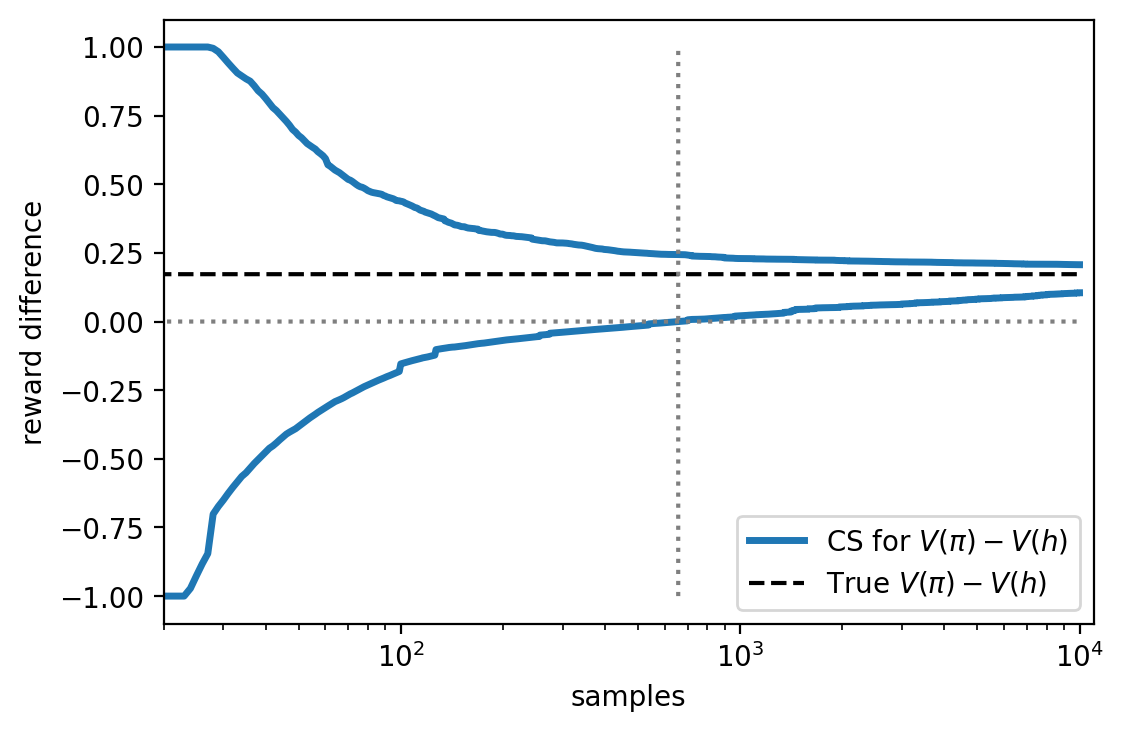

In [536]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap    
fig, ax = plt.subplots(dpi=200)
colors = get_cmap("tab10").colors 
j=7
t = 1+np.arange(len(lbgd))
ax.plot(t,lbgd,'-',color=colors[0],linewidth=2.5, label='CS for $V(\pi)-V(h)$')
ax.plot(t,ubgd,'-',color=colors[0],linewidth=2.5)
ax.plot(t,0.1724665914082657*np.ones_like(t),'k--', label='True $V(\pi)-V(h)$')
ax.plot(t,np.zeros_like(t),':',color=colors[j])
ax.plot(np.argmax(lbgd>0)*np.ones_like(t),np.linspace(-1,1,len(t)),':',color=colors[j])
ax.set(xscale='log',xlim=[20,11000], xlabel='samples', ylabel='reward difference')
ax.legend(loc='lower right')
fig.savefig('gd.pdf', bbox_inches='tight', pad_inches=0)

In [517]:
np.argmax(lbgd>0)

657

In [518]:
print('reward diff:',reward_pi/y.size-reward_h/y.size)

reward diff: 0.1724665914082657


In [545]:
for s in 0,0.5,1,1.05:
    print(np.var(wrc[:,0]*(1-wrc[:,1])-s*(wrc[:,0]-1-wrc[:,2])),s)
    print(np.var(wrc[:,0]*(wrc[:,1])-s*(wrc[:,2])),s)

0.9760183750532692 0
10.704865452558229 0
0.6601372970811202 0.5
3.5259380487449734 0.5
0.8128312787244716 1
0.8128312787244716 1
0.8538723051676598 1.05
0.7871407365810239 1.05


In [575]:
np.var(wrc[:,0]*wrc[:,1]-wrc[:,1])

10.445515171499089

In [ ]:
np.var(wrc[:,0]*wrc[:,1]-wrc[:,1])

In [675]:
chunk = 1000
r_pi = []
r_h = []
iy = y.astype(np.int32)

for i in tqdm.trange(0,50000,chunk):
    probs = pi(X[i:i+chunk])
    r_pi.extend(probs[range(chunk),iy[i:i+chunk]])
    probs = h(X[i:i+chunk])
    r_h.extend(probs[range(chunk),iy[i:i+chunk]])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 16.96it/s]


In [679]:
np.array(r_h)-np.array(r_pi)

array([-0.08912378, -0.08870832, -0.07559895, ..., -0.08800939,
       -0.08936906, -0.08555314])

In [702]:
def bet_1d(data_pi, data_h, wmin, wmax, alpha):
    half_pi = data_pi[:len(data_pi)//2]
    w = np.ones_like(half_pi)
    half_h = data_h[len(data_pi)//2:2*(len(data_pi)//2)]
    lb_pi, ub_pi = opebet.wealth_lb_1d(np.stack((w,half_pi), axis=-1), wmin, wmax, 0.5*alpha)
    lb_h, ub_h = opebet.wealth_lb_1d(np.stack((w,half_h), axis=-1), wmin, wmax, 0.5*alpha)
    return np.array(lb_pi)-np.array(ub_h), np.array(ub_pi)-np.array(lb_h)

def upsample(x):
    c = np.empty((2 * x.size - 1,), dtype=x.dtype)
    c[0::2] = x
    c[1:-1:2] = 0.5*(x[:-1]+x[1:])
    return c

In [712]:
flb = 0
fub = 0
N = 5
for i in range(N):
    lbab, ubab = bet_1d(r_pi[10000*i:10000*(i+1)], r_h[10000*i:10000*(i+1)], 0, 2, 0.01)
    lbab = upsample(lbab)
    ubab = upsample(ubab)
    flb = flb + lbab
    fub = fub + ubab
lbab = flb/N
ubab = fub/N

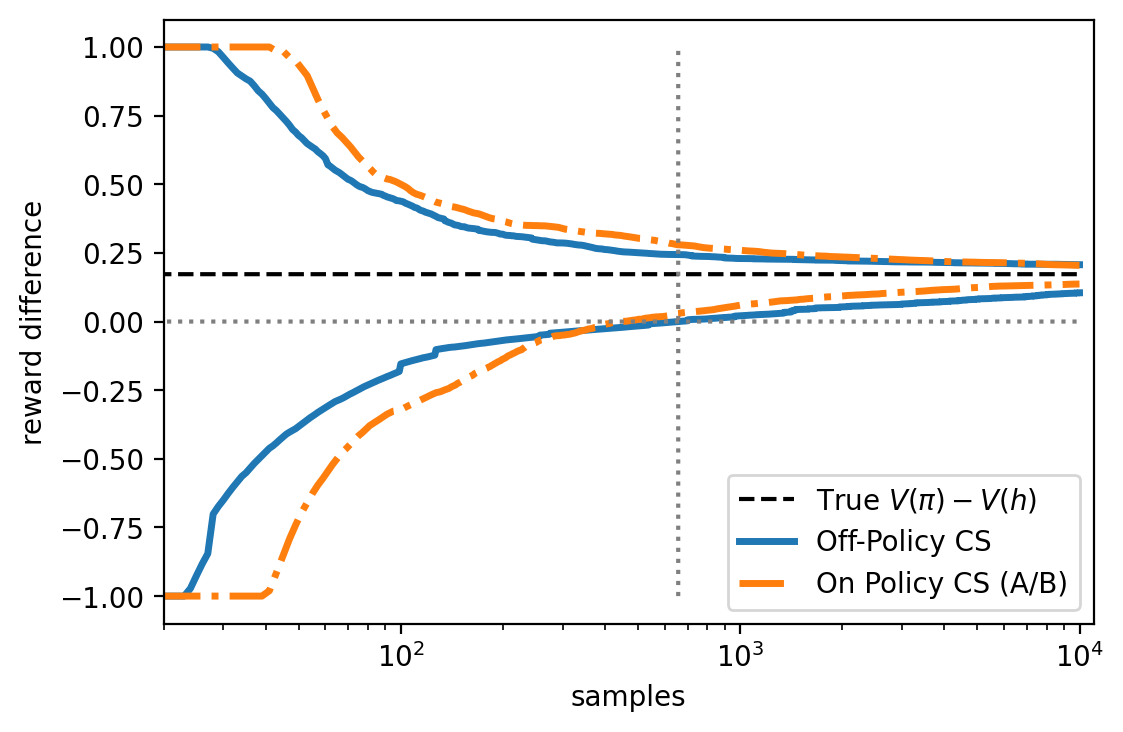

In [719]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap    
fig, ax = plt.subplots(dpi=200)
colors = get_cmap("tab10").colors 
j=7
t = 1+np.arange(len(lbgd))
ta = 1+np.arange(len(lbab))
ax.plot(t,0.1724665914082657*np.ones_like(t),'k--', label='True $V(\pi)-V(h)$')
ax.plot(t,lbgd,'-',color=colors[0],linewidth=2.5, label='Off-Policy CS')
ax.plot(t,ubgd,'-',color=colors[0],linewidth=2.5)
ax.plot(ta,lbab,'-.',color=colors[1],linewidth=2.5, label='On Policy CS (A/B)')
ax.plot(ta,ubab,'-.',color=colors[1],linewidth=2.5)

ax.plot(t,np.zeros_like(t),':',color=colors[j])
ax.plot(np.argmax(lbgd>0)*np.ones_like(t),np.linspace(-1,1,len(t)),':',color=colors[j])
ax.set(xscale='log',xlim=[20,11000], xlabel='samples', ylabel='reward difference')
ax.legend(loc='lower right')
fig.savefig('gd2.pdf', bbox_inches='tight', pad_inches=0)

In [711]:
np.argmax(lbab>0)

656

24999

In [696]:
len(lbab)

25000

In [701]:

upsample(np.arange(4.0))

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. ])